# Reconstructing the evolution of an alpine karst system using conduit network model ensembles #

**Authors:** Chloé Fandel, Ty Ferré, François Miville, Philippe Renard, Nico Goldscheider.

**Keywords:** groundwater, modeling, karst, anisotropic fast marching, conduit networks, hypothesis testing, paleo-springs, karst evolution 

**Note:** Because this model has a stochastic element, each run is likely to be slightly different. The figures in this notebook will therefore not exactly match the published figures.


## Setup, imports, & functions ##
For development, import a local version of pykasso be able to make and test changes.
Import all other needed packages and local modules.
Define custom plotting functions.

In [14]:
#Import a local version of pyKasso by setting the path variable to the path to the local version 
#This allows reloading the module to see changes
import sys
sys.path.append('C:/Users/Chloe/Documents/GitHub/pyKasso/pykasso') #path to local version of package
import base as pk  #in this case, "base" is the name of the .py file with all of the pykasso functions in it

#Check that it worked:
#catchment = pk.SKS() #uncomment this line to create a simple model
#You should see a printed statement indicating that you are using a development version of the package.
#If you do not see this statement, you are using the main version, and changes you make to the local version will have no effect.

In [15]:
#Import the rest of the modules needed:
import os            
import sys           
import importlib
import copy
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import karstnet as kn

#all fast-marching-related imports
import agd
from agd import Eikonal
from agd.Metrics import Riemann

#Local modules:
import importlib.util
spec = importlib.util.spec_from_file_location('swmmpy', 'C:/Users/Chloe/Documents/GitHub/gottesacker/swmmpy.py')
sp = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sp)

os.getcwd()

'C:\\Users\\Chloe\\Documents\\GitHub\\pyKasso\\notebooks'

In [16]:
#Define some custom functions for plotting:
def load_network(data, simplify=False, clean=False, plot=False, ax=None,  plot_nodes=False, labels=[], color='k', alpha=1, lw=1):
    """
    Show the base network as a graph with nodes and edges.

    Inputs: 
    data:   path & name prefix to node and edge data files (ex: folder/subfolder/yournamehere. Files MUST be named 'yournamehere_nodes.dat', and 'yournamehere_links.dat')
    simplify: True/False, whether to simplify network
    clean:  True/False, whether to clean up network
    plot:   True/False, whether to display plot at all or simply return network objects
    ax:     axis to plot on
    plot_nodes:   True/False, whether to display nodes
    labels: None or list of strings ['nodes','edges'], indicating which components to label
    color:  string, single color to use when plotting (cannot have both cmap and color)
    alpha:  float, opacity to plot with (1=opaque, 0=transparent)
    lw:     float, line width

    Outputs:
    k:     karstnet network object
    nodes: node dictionary
    edges: edge dictionary
    ax:    axes plotted on

    """
        
    #Load network:
    k = kn.from_nodlink_dat(data)   #load karstnet graph from files
    if simplify == True:
        nodes  = k.graph_simpl.nodes  #get indices of only the nodes in the simplified graph
        edges  = k.graph_simpl.edges  #get only the edges in the simplified graph
        if clean == True:             #remove erroneous edges (identify them manually by plotting)
            k.graph_simpl.remove_edge(15,1713)  
            k.graph_simpl.remove_edge(17,1644)  
            k.graph_simpl.remove_edge(23,1644)  
            k.graph_simpl.remove_edge(23,1700)  
    else:
        nodes = k.graph.nodes             #get all node indices
        edges = k.graph.edges             #get all edges
        if clean == True:                 #remove erroneous edges (identify them manually by plotting)
            k.graph.remove_edge(4,1701)   #8
            k.graph.remove_edge(15,1702)  #23
            k.graph.remove_edge(17,1644)  #26
            k.graph.remove_edge(20,1701)  #30
            k.graph.remove_edge(23,1644)  #34
            k.graph.remove_edge(23,1700)  #35

    nodes_coord = k.pos2d                                                            #get coordinates of all nodes in complex graph
    nodes  = {node:[nodes_coord[node][0],nodes_coord[node][1]]  for node in nodes}   #make dictionary with node coordinates for plotting
    edges  = {i: edge for i,edge in enumerate(edges)}                                #make dictionary of edges for plotting
    nodes = pd.DataFrame.from_dict(nodes, orient='index', columns=['x','y'])         #convert to pandas for easier plotting
    edges = pd.DataFrame.from_dict(edges, orient='index', columns=['inNode','outNode'])

    #Plot network:
    if plot == True:
        if ax == None:
            fig,ax = plt.subplots(figsize=(10,10))  #create new axes if none are provided
            ax.set_aspect('equal')

        #Calculate start and end coordinates of edges:
        fromX = nodes.x.loc[edges.inNode]       
        fromY = nodes.y.loc[edges.inNode]
        toX   = nodes.x.loc[edges.outNode]
        toY   = nodes.y.loc[edges.outNode]

        #Plot nodes and edges:
        for ind in edges.index:                                                                 #loop over edge indices
            ax.plot((fromX.iloc[ind], toX.iloc[ind]), (fromY.iloc[ind], toY.iloc[ind]), c=color, alpha=alpha, lw=lw)  #plot each edge in same color
        if plot_nodes:
            ax.scatter(nodes.x, nodes.y,  c=color, s=5, alpha=alpha)  #scatterplot nodes
                
        #Add labels:
        if labels == None:
            pass
        else:
            if 'nodes' in labels:                                         #label node indices
                for ind in nodes.index:                                   #loop over node indices
                    ax.annotate(str(ind), xy=(nodes.x[ind]-10, nodes.y[ind]))  #annotate slightly to left of each node
            if 'edges' in labels:                                         
                for ind in edges.index:                                   
                    ax.annotate(str(ind), xy=(fromX.iloc[ind]-10, fromY.iloc[ind]))  #annotate slightly to left of in node of each edge

    return [k,nodes,edges,ax]  
   

def point2index(point, xmin,ymin,zmin, dx,dy,dz):
    '''Convert from x,y,z coordinates to i,j,k indices.'''
    x   = point[0]
    y   = point[1]
    z   = point[2]
    col = int((x - xmin) // dx)
    row = int((y - ymin) // dy)
    lay = int((z - zmin) // dz)
    
    return [col, row, lay]

In [17]:
#Convert files from ArcMap (raster to ASCII tool) to correct orientation and format for pyKasso:
#Only need to do this once.
run = False
if run == True:
    #DEM
    d = np.loadtxt('inputs/paper3/dem181x141.txt')  #load raw text file
    d[d==-9999]=0                                   #replace -9999 with 0 for nan values
    #d = np.flipud(np.rot90(d))                      #re-orient
    d = np.flipud(d)                                #re-orient
    plt.imshow(d, origin='lower')
    print(d.shape, np.unique(d))
    np.savetxt('inputs/paper3/dem181x141.csv', d, delimiter=',') #save as csv

    #Geology from ArcMap
    g = np.loadtxt('inputs/paper3/geo181x141.txt')  #load raw text file
    g[g==-9999]=0                                   #replace -9999 with 0 for nan values
    #g = np.flipud(np.rot90(g))                      #re-orient
    g = np.flipud(g)                                #re-orient
    plt.imshow(g, origin='lower')
    print(g.shape, np.unique(g))
    np.savetxt('inputs/paper3/geo181x141.csv', g, delimiter=',') #save as csv
    
    #Geology from GemPy
    g = np.loadtxt('inputs/paper3/gempy181x141.txt')  #load raw text file
    g[g==-9999]=0                                   #replace -9999 with 0 for nan values
    #g = np.flipud(np.rot90(g))                      #re-orient
    g = np.flipud(g)                                #re-orient
    plt.imshow(g, origin='lower')
    print(g.shape, np.unique(g))
    np.savetxt('inputs/paper3/gempy181x141.csv', g, delimiter=',') #save as csv
    
    #Glacier
    g = np.loadtxt('inputs/paper3/glacier181x141.txt')  #load raw text file
    g[g==0]     = 1                                     #replace 0s with 1s
    g[g==-9999] = 0                                     #replace -9999 with 0 for nan values
    #g = np.flipud(np.rot90(g))                         #re-orient
    g = np.flipud(g)                                    #re-orient
    plt.imshow(g, origin='lower')
    print(g.shape, np.unique(g))
    np.savetxt('inputs/paper3/glacier181x141.csv', g, delimiter=',') #save as csv
    
    #Geology masked by glacier
    geo = np.loadtxt('inputs/paper3/geo181x141.csv',delimiter=',')
    print(geo.shape, np.unique(geo))
    glacier = np.loadtxt('inputs/paper3/glacier181x141.csv',delimiter=',')
    print(glacier.shape, np.unique(glacier))
    geo[glacier==1] = 5    #assign glaciated extent to a new geologic unit (unkarstifiable)
    np.savetxt('inputs/paper3/geo_glacier181x141.csv', geo, delimiter=',') #save as csv
    
    #Faults:
    faults = np.loadtxt('inputs/paper3/faults181x141.csv', delimiter=',')  #load raw csv file
    matplotlib.image.imsave('inputs/paper3/faults181x141.png', faults, cmap='gray_r') #convert to png image

## Gottesacker/Schwarzwassertal karst system ##
The extensively-studied Gottesacker/Schwarzwassertal karst system is located in the German/Austrian Alps (Goldscheider, 2005). This system consists of a series of plunging synclines and anticlines draining to the Schwarzwasser stream valley, which cuts roughly perpendicularly across the fold axes. The karst aquifer lies north of the valley in a limestone unit overlain by sandstone and underlain by non-karstifiable marl and older units (several other units are present, but for the purposes of conduit modeling, the geology has been simplified to only these four). Three major springs drain the system. South of the valley, unkarstifiable lithology prevents conduit development.

### Reference map ###
Simulating the entire network under present-day conditions

CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity

 - orientation entropy,aspl,cpd,md,cv degree,cvd


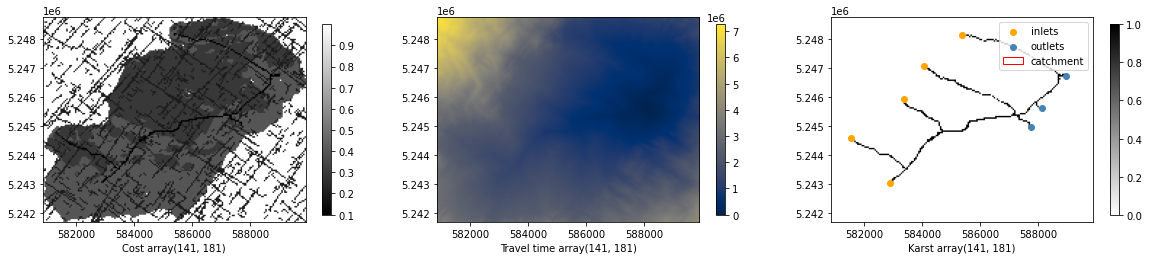

In [18]:
#Load model and simulate anisotropic network with multiple springs:
catchment = pk.SKS('inputs/paper3/settings.yaml')          #import settings and options from input folder
catchment.compute_karst_network()                               #run the model to calculate the karst network
catchment.show()


 This network contains  1  connected components

Graph successfully created from file !


 This network contains  1  connected components

Graph successfully created from file !



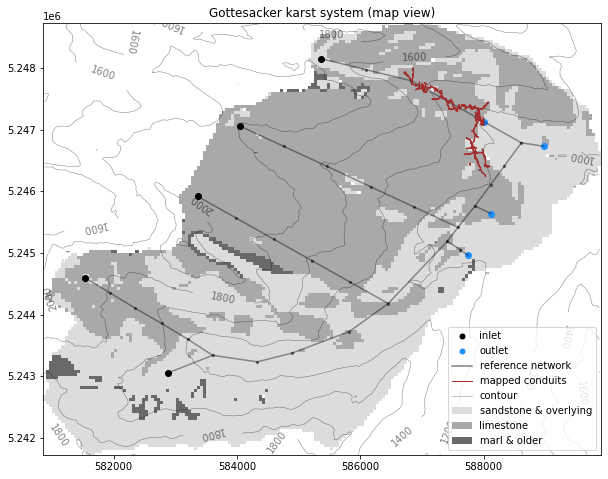

In [21]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, aspect='equal')  
ax.set_title('Gottesacker karst system (map view)')

cmap_geo = matplotlib.colors.ListedColormap(['white','gainsboro','darkgrey','dimgrey','dimgrey'])   #geology colormap
cmap_frac = matplotlib.colors.ListedColormap(['whitesmoke'])                                        #fracture colormap
cmap_frac.set_under(color='w', alpha=0)                                                             #set values under limit to transparent
frac = catchment.geology.data['fractures']['data'].copy()                                           #get fracture array
frac[frac<1] = -1                                                                                   #set all non-fracture cells under limit (prevents them from displaying)

plt.imshow(catchment.geology.data['geology']['data'], origin='lower', extent=catchment.grid.extent, cmap=cmap_geo)
#plt.imshow(frac,                                      origin='lower', extent=catchment.grid.extent, cmap=cmap_frac,     vmin=0,vmax=1)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=0.5)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
load_network('inputs/paper3/base', plot=True, ax=ax, plot_nodes=True, lw=1.5, alpha=0.4)
load_network('inputs/paper3/holloch3D', clean=True, plot=True, ax=ax, color='brown')
#catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=[], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')  
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')
plt.scatter(588006.66, 5247129.20, c='dodgerblue')

label = False
if label:
    inlet_labels  = ['N21', 'N16', 'N1', 'N6', 'N11']
    outlet_labels = ['QS', 'QE', 'QA']
    for i,inlet in enumerate(catchment.inlets):
        ax.annotate(inlet_labels[i],  xy=(inlet[0]-400,  inlet[1]))
    for o,outlet in enumerate(catchment.outlets):
        ax.annotate(outlet_labels[o], xy=(outlet[0]+100, outlet[1]), c='dodgerblue')
    ax.annotate('QO', xy=(588006.66+100, 5247129.20), c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          #matplotlib.lines.Line2D([0], [0], color='k',     lw=2,   label='simulated network'),
          matplotlib.lines.Line2D([0], [0], color='gray',  lw=1.5, label='reference network'),
          matplotlib.lines.Line2D([0], [0], color='brown', lw=1,   label='mapped conduits'),
          matplotlib.lines.Line2D([0], [0], color='gray',  lw=0.5, label='contour'),
          #matplotlib.lines.Line2D([0], [0], color='k',     lw=1,   label='cross-section'),
          #matplotlib.lines.Line2D([0], [0], color='r',     lw=1,   label='boundary'),
          matplotlib.patches.Patch(facecolor='gainsboro',  label='sandstone & overlying'),
          matplotlib.patches.Patch(facecolor='darkgray',   label='limestone'),
          matplotlib.patches.Patch(facecolor='dimgrey',    label='marl & older')]
plt.legend(handles=legend, loc=[.725,.01]) #to put on right side: loc=[1.01,0.5], to put in right corner: loc=[0.72,0.01], to put in left corner: loc=[0.01,0.01]

## Hölloch cave system ##



 This network contains  1  connected components

Graph successfully created from file !



c:\users\chloe\documents\github\karstnet-master\karstnet-master\karstnet\base.py:353: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


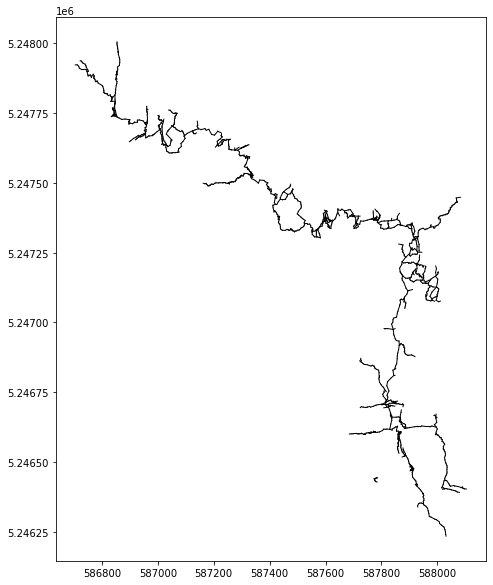

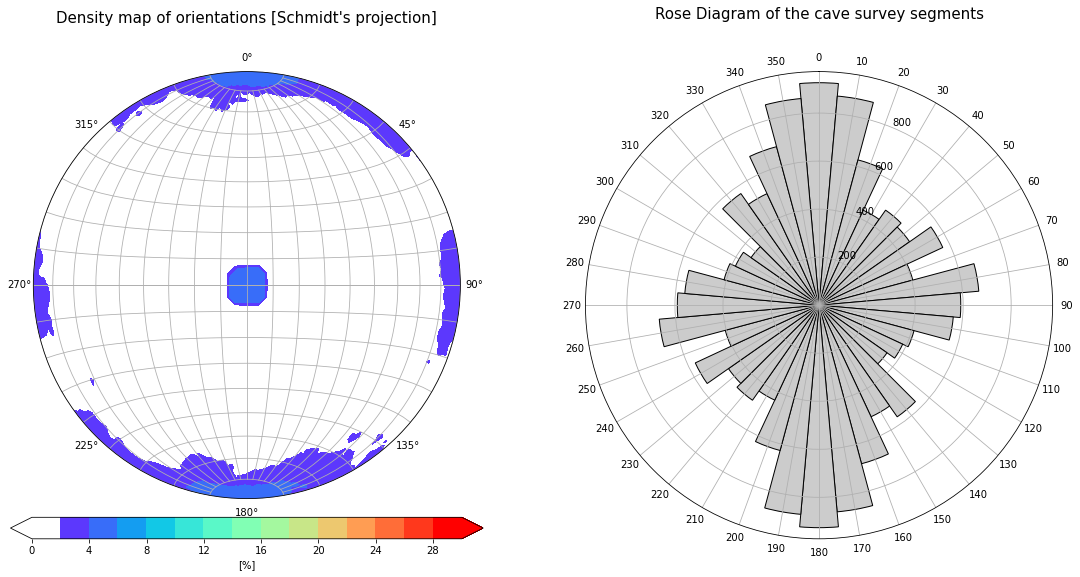


 This network contains :
 1714  nodes (stations) and  1752  edges.
  On the simplified graph, there are :  351  nodes (stations) and  395  edges,
 135  are extremity nodes (entries or exits) and  193  are junction nodes.
There is/are  1  connected component.s and  45  cycle.s.


Howard's parameter are (Howard, 1970) :  
 alpha:  0.06456241032998565 
 beta 1.1253561253561253 
 gamma 0.3772683858643744

Note that this computation considers the node of degree 2  necessary to loop preservations as Seed Nodes, in order to  stay consistent with Howard's illustrations.
Computing:
 - mean length,cv length,length entropy,mean tortuosity

 - orientation entropy,aspl,cpd,md,cv degree,cvd


{'mean length': 57.42285774845878,
 'cv length': 4.00842659681307,
 'length entropy': 0.03387443035010009,
 'tortuosity': 1.272714613721442,
 'orientation entropy': 0.9862498634989331,
 'aspl': 22.38635734635735,
 'cpd': 0.45559258990702406,
 'mean degree': 2.2507122507122506,
 'cv degree': 0.4796701833442699,
 'correlation vertex degree': -0.2979928403563412}

In [7]:
[holloch,holloch_nodes,holloch_edges,ax] = load_network('inputs/paper3/holloch3D', clean=True, plot=True)
holloch.stereo()                                          #plot stereonet & rose diagram
holloch.basic_analysis()
holloch.characterize_graph()

## Hypothesis 1: glaciation ##
Only the overflow spring is active (all other springs covered by glacier).
Inlet N21 (farthest SW) is inactive (covered by glacier).
Inlet N1 is possibly inactive?

CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


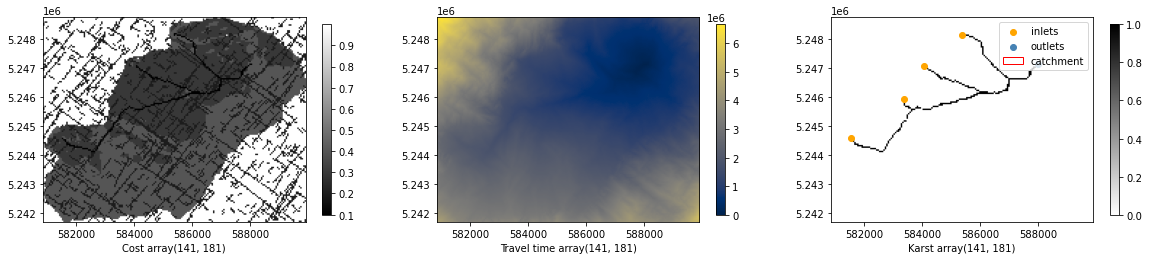

In [8]:
#Load model and simulate anisotropic network with multiple springs:
catchment = pk.SKS('inputs/paper3/settings.yaml')                     #import settings and options from input folder
catchment.set_geological_datafile('inputs/paper3/geo_glacier181x141.csv')     #replace gempy geology with arcmap geology
catchment.set_geology_id([0,1,2,3,4,5])                               #add glacier id
catchment.set_geology_cost([catchment.settings['cost_out'], catchment.settings['cost_aquiclude'], 
                            catchment.settings['cost_aquifer'], catchment.settings['cost_aquiclude'], 
                            catchment.settings['cost_aquiclude'], catchment.settings['cost_aquiclude']])
catchment.set_inlets_data('inputs/paper3/inlets2D_hypothesis1.txt')   #load new inlet file
catchment.set_outlets_data('inputs/paper3/outlets2D_hypothesis1.txt') #load new outlet file
catchment.set_outlets_importance([1])                                 #only one outlet to iterate over
catchment.set_inlets_per_outlet([1])                                  #only one outlet to iterate over
catchment.set_inlets_importance([1,1,1,1])                            #assign each inlet to its own iteration
catchment.update_all()                                                #update model for changes to take effect
catchment.compute_karst_network()                                     #run the model to calculate the karst network
catchment.show()


 This network contains  1  connected components

Graph successfully created from file !


 This network contains  1  connected components

Graph successfully created from file !



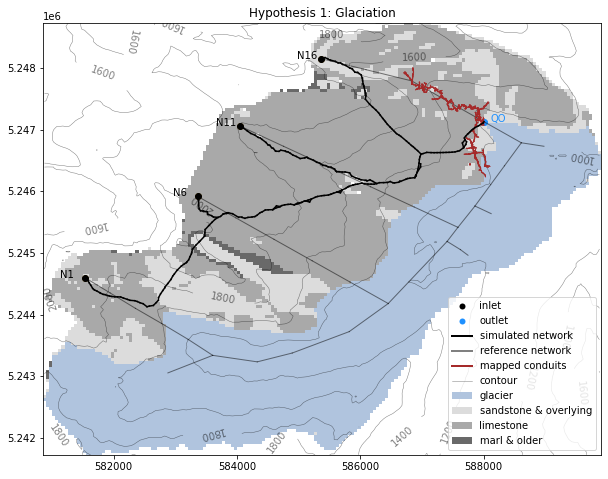

In [9]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, aspect='equal')  
ax.set_title('Hypothesis 1: Glaciation')

cmap_glac = matplotlib.colors.ListedColormap(['white','gainsboro','darkgrey','dimgrey','dimgrey','lightsteelblue'])   #geology colormap
faults = catchment.get_faults().copy()                                           #get faults array
faults[faults<1] = -1                                                            #set non-fault cells to not display
frac = catchment.get_fractures().copy()                                           #get faults array
frac[frac<1] = -1                                                            #set non-fault cells to not display

plt.imshow(catchment.get_geology(), origin='lower', extent=catchment.grid.extent, cmap=cmap_glac)
#plt.imshow(faults,                  origin='lower', extent=catchment.grid.extent, cmap=cmap_frac,  vmin=0,vmax=1)
#plt.imshow(frac,                    origin='lower', extent=catchment.grid.extent, cmap=cmap_frac,  vmin=0,vmax=1)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=0.5)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
load_network(data='inputs/gottesacker/base', plot=True, ax=ax, alpha=0.5)                                                 #plot base network
load_network('inputs/paper3/holloch3D', clean=True, plot=True, ax=ax, color='brown')
catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=[], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')  
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

label = True
if label:
    inlet_labels  = ['N1', 'N11', 'N16',  'N6']
    outlet_labels = ['QO']
    for i,inlet in enumerate(catchment.inlets):
        ax.annotate(inlet_labels[i],  xy=(inlet[0]-400,  inlet[1]))
    for o,outlet in enumerate(catchment.outlets):
        ax.annotate(outlet_labels[o], xy=(outlet[0]+100, outlet[1]), c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k',     lw=2,   label='simulated network'),
          matplotlib.lines.Line2D([0], [0], color='gray',  lw=2,   label='reference network'),
          matplotlib.lines.Line2D([0], [0], color='brown', lw=2,   label='mapped conduits'),
          matplotlib.lines.Line2D([0], [0], color='gray',  lw=0.5, label='contour'),
          matplotlib.patches.Patch(facecolor='lightsteelblue', label='glacier'),
          #matplotlib.patches.Patch(facecolor='whitesmoke', label='fractures'),
          matplotlib.patches.Patch(facecolor='gainsboro',  label='sandstone & overlying'),
          matplotlib.patches.Patch(facecolor='darkgray',   label='limestone'),
          matplotlib.patches.Patch(facecolor='dimgrey',    label='marl & older')]
plt.legend(handles=legend, loc=[.725,.01]) #to put on right side: loc=[1.01,0.5], to put in right corner: loc=[0.72,0.01], to put in left corner: loc=[0.01,0.01]


In [338]:
#Iterate over many versions:
shuffle = False

catchment = pk.SKS('inputs/paper3/settings.yaml')                     #import settings and options from input folder
catchment.set_geological_datafile('inputs/paper3/geo_glacier181x141.csv')     #replace gempy geology with arcmap geology
catchment.set_geology_id([0,1,2,3,4,5])                               #add glacier id
catchment.set_geology_cost([catchment.settings['cost_out'], catchment.settings['cost_aquiclude'], 
                            catchment.settings['cost_aquifer'], catchment.settings['cost_aquiclude'], 
                            catchment.settings['cost_aquiclude'], catchment.settings['cost_aquiclude']])
catchment.set_inlets_data('inputs/paper3/inlets2D_hypothesis1.txt')   #load new inlet file
catchment.set_outlets_data('inputs/paper3/outlets2D_hypothesis1.txt') #load new outlet file
catchment.set_outlets_importance([1])                                 #only one outlet to iterate over
catchment.set_inlets_per_outlet([1])                                  #only one outlet to iterate over
catchment.set_inlets_importance([1,1,1,1])                            #assign each inlet to its own iteration
if shuffle:
    catchment.set_inlets_shuffle(True)                                    #shuffle inlet order each run

n = 100                                                                #number of iterations to calculate (caution: more than 10 is slow)
for i in range(n):
    catchment.update_all()                                            #update model for changes to take effect
    catchment.compute_karst_network() 

CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean 

shuffle =  False

 This network contains  1  connected components

Graph successfully created from file !



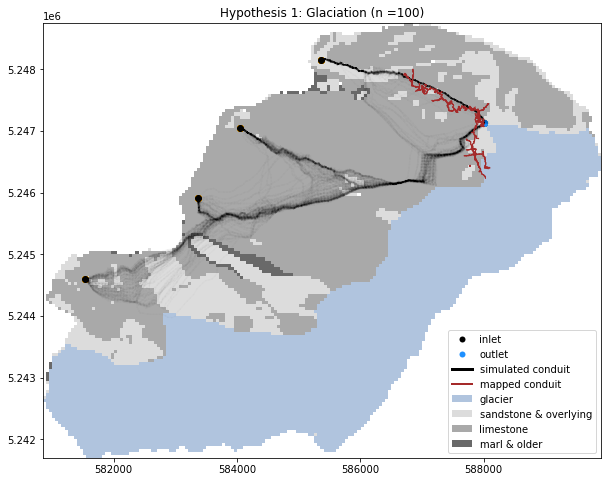

In [341]:
#Plot many iterations:
print('shuffle = ', shuffle)
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, aspect='equal')
ax.set_title('Hypothesis 1: Glaciation (n ='+str(n)+')')

plt.imshow(catchment.get_geology(), origin='lower', extent=catchment.grid.extent, cmap=cmap_glac)
for i in range(n):
    catchment.show_network(ax=ax, data=catchment.karst_simulations[i], simplify=False, labels=[], plot_nodes=False, legend=False, color='k', alpha=1/n)
load_network('inputs/paper3/holloch3D', clean=True, plot=True, ax=ax, color='brown')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')
#ax.annotate('QO', xy=(catchment.outlets[:,0]+100, catchment.outlets[:,1]), c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k',     lw=3,      label='simulated conduit'),
          matplotlib.lines.Line2D([0], [0], color='brown', lw=2,      label='mapped conduit'),
          matplotlib.patches.Patch(facecolor='lightsteelblue', label='glacier'),
          matplotlib.patches.Patch(facecolor='gainsboro', label='sandstone & overlying'),
          matplotlib.patches.Patch(facecolor='darkgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='dimgrey',   label='marl & older')]
plt.legend(handles=legend, loc=[.725,.01])

## Hypothesis 2: Sagebach covered ##
The network is the same in all respects except that the Sagebach spring is covered by overlying units.

CAUTION: You are using the development version of this package.

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


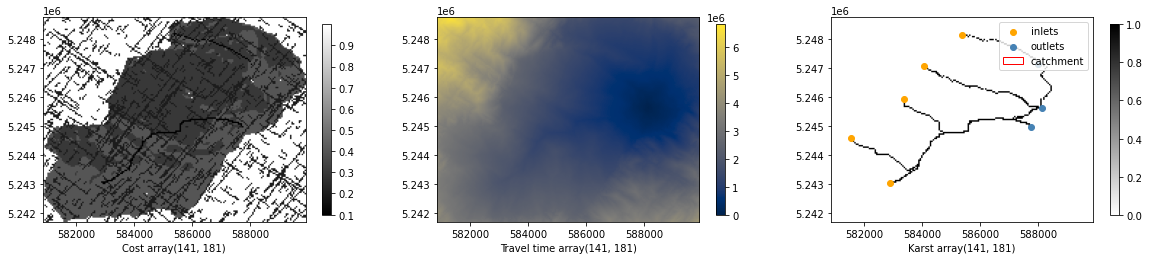

In [10]:
#Load model and simulate anisotropic network with multiple springs:
catchment = pk.SKS('inputs/paper3/settings.yaml')                     #import settings and options from input folder
catchment.set_geological_datafile('inputs/paper3/geo181x141.csv')     #replace gempy geology with arcmap geology
catchment.set_inlets_data('inputs/paper3/inlets2D_hypothesis2b.txt')   #load new inlet file
catchment.set_outlets_data('inputs/paper3/outlets2D_hypothesis2b.txt') #load new outlet file
catchment.set_outlets_importance([1,1,1])                             #assign each outlet to an iteration (3 outlets total)
#catchment.set_inlets_per_outlet([1,1,3])                              #distribute inlets evenly between outlets
catchment.set_inlets_per_outlet([1,1,4])                             #hypothesis 2b (QO-QA connection exists)
catchment.set_inlets_importance([1])                                  #assign all inlets to a single iteration (5 inlets total)
catchment.update_all()                                                #update model for changes to take effect
catchment.compute_karst_network()                                     #run the model to calculate the karst network
catchment.show()


 This network contains  1  connected components

Graph successfully created from file !



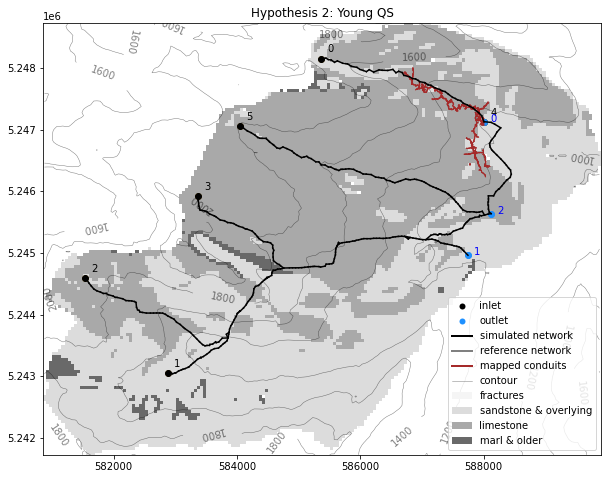

In [11]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, aspect='equal')  
ax.set_title('Hypothesis 2: Young QS')

faults = catchment.get_faults().copy()                                           #get faults array
faults[faults<1] = -1                                                            #set non-fault cells to not display
frac = catchment.get_fractures().copy()                                           #get faults array
frac[frac<1] = -1                                                            #set non-fault cells to not display


plt.imshow(catchment.get_geology(), origin='lower', extent=catchment.grid.extent, cmap=cmap_geo)
#plt.imshow(faults,                  origin='lower', extent=catchment.grid.extent, cmap=cmap_frac,     vmin=0,vmax=1)
#plt.imshow(frac,                    origin='lower', extent=catchment.grid.extent, cmap=cmap_frac,     vmin=0,vmax=1)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=0.5)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
#load_network('inputs/gottesacker/base', plot=True, ax=ax, alpha=0.5)                                                 #plot base network
load_network('inputs/paper3/holloch3D', clean=True, plot=True, ax=ax, color='brown')
catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=[ ], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')  
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')
for i,inlet in enumerate(catchment.inlets):
    ax.annotate(str(i), xy=(inlet[0]+100,inlet[1]+100),color='k')
for o,outlet in enumerate(catchment.outlets):
    ax.annotate(str(o), xy=(outlet[0]+100,outlet[1]),color='b')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k',     lw=2,   label='simulated network'),
          matplotlib.lines.Line2D([0], [0], color='gray',  lw=2,   label='reference network'),
          matplotlib.lines.Line2D([0], [0], color='brown', lw=2,   label='mapped conduits'),
          matplotlib.lines.Line2D([0], [0], color='gray',  lw=0.5, label='contour'),
          matplotlib.patches.Patch(facecolor='whitesmoke', label='fractures'),
          matplotlib.patches.Patch(facecolor='gainsboro', label='sandstone & overlying'),
          matplotlib.patches.Patch(facecolor='darkgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='dimgrey',   label='marl & older')]
plt.legend(handles=legend, loc=[.725,.01]) #to put on right side: loc=[1.01,0.5], to put in right corner: loc=[0.72,0.01], to put in left corner: loc=[0.01,0.01]


In [12]:
#Iterate over many versions:
shuffle = False
catchment = pk.SKS('inputs/paper3/settings.yaml')
catchment.set_geological_datafile('inputs/paper3/geo181x141.csv')     #replace gempy geology with arcmap geology
catchment.set_inlets_data('inputs/paper3/inlets2D_hypothesis2b.txt')   #load new inlet file
catchment.set_outlets_data('inputs/paper3/outlets2D_hypothesis2b.txt') #load new outlet file
catchment.set_outlets_importance([1,1,1])                             #each outlet with its own iteration
#catchment.set_inlets_per_outlet([1,1,3])                              #distribute inlets 
catchment.set_inlets_per_outlet([1,1,4])                              #distribute inlets 
catchment.set_inlets_importance([1])                                  #all inlets in a single iteration per outlet
if shuffle:
    catchment.set_inlets_shuffle(True)                                    #shuffle inlet order each run
    catchment.set_outlets_shuffle(True)                                   #shuffle outlet order each run

n = 100                                                                #number of iterations to calculate (caution: more than 10 is slow)
for i in range(n):
    catchment.update_all()                                            #update model for changes to take effect
    catchment.compute_karst_network() 

CAUTION: You are using the development version of this package.

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean 

shuffle =  False

 This network contains  1  connected components

Graph successfully created from file !



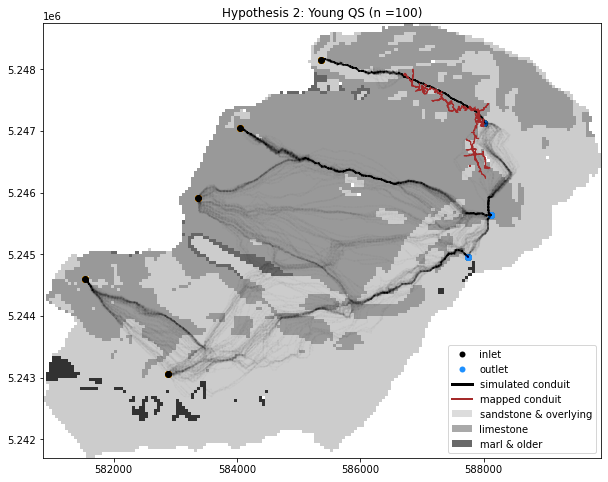

In [13]:
#Plot many iterations:
print('shuffle = ', shuffle)
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, aspect='equal')
ax.set_title('Hypothesis 2: Young QS (n ='+str(n)+')')

plt.imshow(catchment.get_geology(), origin='lower', extent=catchment.grid.extent, cmap='gray_r', vmin=0,vmax=5)
for i in range(n):
    catchment.show_network(ax=ax, data=catchment.karst_simulations[i], simplify=False, labels=[], plot_nodes=False, legend=False, color='k', alpha=1/n)
load_network('inputs/paper3/holloch3D', clean=True, plot=True, ax=ax, color='brown')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color='k',     lw=3,      label='simulated conduit'),
          matplotlib.lines.Line2D([0], [0], color='brown', lw=2,      label='mapped conduit'),
          matplotlib.patches.Patch(facecolor='gainsboro', label='sandstone & overlying'),
          matplotlib.patches.Patch(facecolor='darkgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='dimgrey',   label='marl & older')]
plt.legend(handles=legend, loc=[.725,.01])